# Long Short Term Memory(LSTM)

The challenge to address long-term information preservation and short-term input skipping in latent variable models has existed for a long time. One of the earliest approaches to address this was the LSTM by [Hochreiter and Schmidhuber, $1997^{179}$](http://papers.nips.cc/paper/1215-lstm-can-solve-hard-long-time-lag-problems.pdf). It shares many of the properties of the Gated Recurrent Unit (GRU) and predates it by almost two decades. Its design is slightly more complex.
Arguably it is inspired by logic gates of a computer. To control a memory cell we need a number of gates. One gate is needed to read out the entries from the cell (as opposed to reading any other cell). We will refer to this as the output gate. A second gate is needed to decide when to read data into the cell. We refer to this as the input gate. Lastly, we need a mechanism to reset the contents of the cell, governed by a forget gate. The motivation for such a design is the same as before, namely to be able to decide when to remember and when to ignore inputs into the latent state via a dedicated mechanism. Let’s see how this works in practice.

# Gated Memory Cells
Three gates are introduced in LSTMs: the input gate, the forget gate, and the output gate. In addition to that we introduce memory cells that take the same shape as the hidden state. Strictly speaking this is just a fancy version of a hidden state, custom engineered to record additional information.

# Input Gates, Forget Gates and Output Gates
Just like with GRUs, the data feeding into the LSTM gates is the input at the current time step $X_t$ and the hidden state of the previous time step $H_{t−1}$. These inputs are processed by a fully connected layer and a sigmoid activation function to compute the values of input, forget and output gates. As a result, the three gate elements all have a value range of [0, 1].



We assume there are *h* hidden units and that the minibatch is of size *n*. Thus the input is $X_t$ ∈ $R^{n×d}$ (number of examples: n, number of inputs: d) and the hidden state of the last time step is $H_{t−1}$ ∈ $R^{n×h}$. Correspondingly the gates are defined as follows: the input gate is $I_t$ ∈ $R^{n×h}$, the forget gate is $F_t$ ∈ $R^{n×h}$, and the output gate is $O_t$ ∈ $R^{n×d}$. They are calculated as follows:
$$I_t = σ(X_t W_{xi} + H_{t−1} W_{hi} + b_i )$$
$$F_t = σ(X_t W_{xf} + H_{t−1} W_{hf} + b_f )$$
$$O_t = σ(X_t W_{xo} + H_{t−1} W_{ho} + b_o )$$
$W_{xi}$, $W_{xf}$, $W_{xo}$ ∈ $R^{d×h}$ and $W_{hi}$, $W_{hf}$, $W_{ho}$ ∈ $R^{h×h}$ are weight parameters and $B_i$, $b_f$ , $b_o$ ∈ $R^{1×h}$ are bias
parameters.

# Candidate Memory Cell

Next we design a memory cell. Since we haven’t specified the action of the various gates yet, we first introduce a candidate memory cell $\tilde{C_t}$ ∈ $R^{n×h}$. Its computation is similar to the three gates described above, but using a tanh function with a 

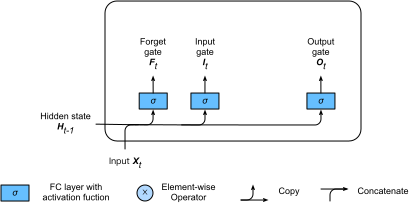

In [1]:
from IPython.display import SVG
SVG(filename= '../img/lstm_0.svg')

Fig. 10.9.1: Calculation of input, forget, and output gates in an LSTM.

value range for [−1, 1] as activation function. This leads to the following equation at time step t.

$$\tilde{C_t} = tanh(X_t W_{xc} + H_{t−1} W_{hc} + b_c )$$

Here $W_{xc}$ ∈ $R^{d×h}$ and $W_{hc}$ ∈ $R^{h×h}$ are weights and $b_c$ ∈ $R^{1×h}$ is a bias.

# Memory Cell
In GRUs we had a single mechanism to govern input and forgetting. Here we have two parameters, $I_t$ which governs how much we take new data into account via $\tilde{C_t}$ and the forget parameter $F_t$ which addresses how much we of the old memory cell content $C_{t−1}$ ∈ $R^{n×h}$ we retain. Using the same pointwise multiplication trick as before we arrive at the following update equation.

$$Ct = F_t ⊙ C_{t−1} +I_t ⊙ \tilde{C_t}.$$

If the forget gate is always approximately 1 and the input gate is always approximately 0, the past memory cells will be saved over time and passed to the current time step. This design was introduced to alleviate the vanishing gradient problem and to better capture dependencies for time series with long range dependencies. We thus arrive at the following flow diagram.

# Hidden States
Lastly we need to define how to compute the hidden state $H_t$ ∈ $R^{n×h}$. This is where the output gate comes into play. In the LSTM it is simply a gated version of the tanh of the memory cell. This ensures that the values of $H_t$ are always in the interval [−1, 1]. Whenever the output gate is 1 we effectively pass all memory information through to the predictor whereas for output 0 we retain all information only within the memory cell and perform no further processing. The figure below has a graphical illustration of the data flow.

$$H_t = O_t ⊙ tanh(C_t).$$



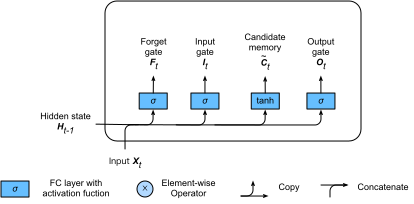

In [2]:
SVG(filename= '../img/lstm_1.svg')

Fig. 10.9.2: Computation of candidate memory cells in LSTM.

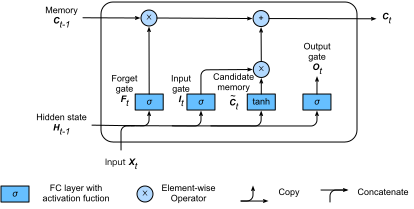

In [3]:
SVG(filename= '../img/lstm_2.svg')

Fig. 10.9.3: Computation of memory cells in an LSTM. Here, the multiplication is carried out element-wise.

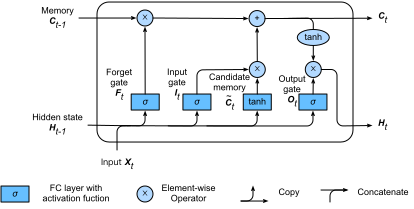

In [4]:
SVG(filename= '../img/lstm_3.svg')

Fig. 10.9.4: Computation of the hidden state. Multiplication is element-wise.

# Implementation from Scratch

Now it’s time to implement an LSTM. We begin with a model built from scratch. As with the experiments in the previous sections we first need to load the data. We use The Time Machine for this.

In [5]:
import sys
sys.path.insert(0, '..')

import d2l
import torch
import torch.nn as nn
from d2l import RNNModel 
from d2l import load_data_time_machine
from d2l import train_and_predict_rnn
from d2l import train_and_predict_rnn_nn
torch.set_default_tensor_type('torch.cuda.FloatTensor')

corpus_indices, vocab = load_data_time_machine()

# Initialize Model Parameters
Next we need to define and initialize the model parameters. As previously, the hyperparameter num_hiddens defines the number of hidden units. We initialize weights with a Gaussian with 0.01 variance and we set the biases to 0.

In [6]:
num_inputs, num_hiddens, num_outputs = len(vocab), 256, len(vocab)
device = d2l.try_gpu()
print('Using', device)

Using cuda:0


In [7]:
def get_params():
    def _one(shape):
        return torch.randn(shape, device=device).normal_(std=0.01)
    
    def _three():
        return (_one((num_inputs, num_hiddens)),
                _one((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))
    W_xi,W_hi,b_i = _three() #Input gate parameters
    W_xf,W_hf,b_f = _three() #Forget gate parameters
    W_xo,W_ho,b_o = _three() #Output hidden state parameters
    W_xc,W_hc,b_c = _three() # Candidate cell parameters
    #Output layer paramters
    W_hq = _one((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Create gradient
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

# Define the Model
In the initialization function, the hidden state of the LSTM needs to return an additional memory cell with a value of 0 and a shape of (batch size, number of hidden units). Hence we get the following state initialization.

In [8]:
def init_lstm_state(batch_size, num_hiddens, device):
    return  (torch.zeros(size=(batch_size, num_hiddens), device=device),
             torch.zeros(size=(batch_size, num_hiddens), device=device))

The actual model is defined just like we discussed it before with three gates and an auxiliary memory cell. Note that only the hidden state is passed on to the output layer. The memory cells do not participate in the computation directly.

In [9]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q] = params
    (H, C) = state 
    outputs = []
    for X in inputs:
        sigmoid = nn.Sigmoid()
        I = sigmoid(torch.matmul(X.float(), W_xi) + torch.matmul(H.float(), W_hi) + b_i)
        F = sigmoid(torch.matmul(X.float(), W_xf) + torch.matmul(H.float(), W_hf) + b_f)
        O = sigmoid(torch.matmul(X.float(), W_xo) + torch.matmul(H.float(), W_ho) + b_o)
        tanh = nn.Tanh()
        C_tilda = tanh(torch.matmul(X.float(), W_xc) + torch.matmul(H.float(), W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * C.tanh()
        Y = torch.matmul(H.float(), W_hq) + b_q
        outputs.append(Y)
    return outputs, (H, C)

# Training and Prediction
As in the previous section, during model training, we only use adjacent sampling. After setting the hyper- parameters, we train and model and create a 50 character string of text based on the prefixes “traveller” and “time traveller”.

In [10]:
num_epochs, num_steps, batch_size, lr, clipping_theta = 100, 35, 32, 3, 1
prefixes = ['traveller', 'time traveller']
train_and_predict_rnn(lstm, get_params, init_lstm_state, num_hiddens, 
                      corpus_indices, vocab, device, False, num_epochs,
                      num_steps, lr, clipping_theta, batch_size, prefixes)

epoch 50, perplexity 10.252556, time 29.76 sec
epoch 100, perplexity 5.957661, time 40.47 sec
 - traveller the timension of there thenesting the timension o
 - time traveller the timension of there thenesting the timension o


# Concise Implementation
We can call the LSTM class in the rnn module directly to instantiate the model.

In [11]:
lstm_layer = nn.LSTM(input_size=num_inputs, hidden_size=num_hiddens)
model = RNNModel(lstm_layer, num_hiddens, len(vocab))
model.to(device)
train_and_predict_rnn_nn(model, num_hiddens, init_lstm_state, corpus_indices, vocab,
                         device, num_epochs*5, num_steps, lr,
                         clipping_theta, batch_size, prefixes, 2)

epoch 125, perplexity 1.837382, time 46.93 sec
epoch 250, perplexity 1.044730, time 47.20 sec
 - traveller smiled. 'are you sure we can move freely in space
 - time traveller smiled. 'are you sure we can move freely in space
epoch 375, perplexity 1.034328, time 47.27 sec
epoch 500, perplexity 1.029750, time 59.48 sec
 - traveller smiled. 'are you sure we can move freely in space
 - time traveller smiled. 'are you sure we can move freely in space


# Summary
• LSTMs have three types of gates: input, forget and output gates which control the flow of information.

• The hidden layer output of LSTM includes hidden states and memory cells. Only hidden states are passed into the output layer. Memory cells are entirely internal.

• LSTMs can help cope with vanishing and exploding gradients due to long range dependencies and short-range irrelevant data.

• In many cases LSTMs perform slightly better than GRUs but they are more costly to train and execute due to the larger latent state size.

• LSTMs are the prototypical latent variable autoregressive model with nontrivial state control. Many variants thereof have been proposed over the years, e.g. 
multiple layers, residual connections, different types of regularization.

• Training LSTMs and other sequence models is quite costly due to the long dependency of the sequence. Later we will encounter alternative models such as transformers that can be used in some cases.
# Exercises
1. Adjust the hyperparameters. Observe and analyze the impact on runtime, perplexity, and the generted output.
2. How would you need to change the model to generate proper words as opposed to sequences of char- acters?
3. Compare the computational cost for GRUs, LSTMs and regular RNNs for a given hidden dimension. Pay special attention to training and inference cost
4. Since the candidate memory cells ensure that the value range is between -1 and 1 using the tanh function, why does the hidden state need to use the tanh function again to ensure that the output value range is between -1 and 1?
5. Implement an LSTM for time series prediction rather than character sequences.
# References
[1] Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory. Neural computation, 9(8), 1735- 1780.

